# Fitting a Line Using MCMC
By: Griffin Hosseinzadeh (2019 April 17)

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import emcee
import corner

%matplotlib inline

## Generate Some Fake Data
Choose a slope $m$, intercept $b$, and scatter $\sigma$, and generate $N$ random points using the `np.random` module. Plot the results to see what your data look like. Our goal is to recover the parameters defined here. (Hint: this section is identical to the previous notebook.)

<ErrorbarContainer object of 3 artists>

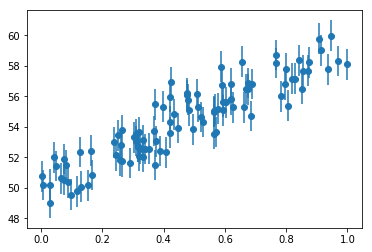

In [2]:
N = 100  # number of points
m = 10.  # slope
b = 50.  # intercept
sigma = 1.  # scatter

x = np.random.rand(N)
y = m * x + b + sigma * np.random.randn(N)
dy = np.repeat(sigma, N)
plt.errorbar(x, y, dy, fmt='o')

## Write Down the Posterior
Define functions that return the prior, the likelihood, and the posterior given a parameter vector `theta = [m, b]`. For computational accuracy (and convenience), we actually want to do this in log space. You can either use `np.log` (natural log) or `np.log10` (base-10 log). Regardless of the shape of your prior, it's good practice to limit the values of $m$ and $b$ to some reasonable range. (Hint: this section is identical to the previous notebook.)

In [3]:
m_min = 0.
m_max = 100.
b_min = 0.
b_max = 100.

def log_prior(theta):
    """
    Returns log(prior) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    
    Returns
    -------
    ln_prior: float
        Natural log of the prior probability function
    """

    if m_min < theta[0] < m_max and b_min < theta[1] < b_max:
        ln_prior = -np.log(theta[0])
    else:
        ln_prior = -np.inf
    return ln_prior


def log_likelihood(theta, x, y, dy):
    """
    Returns log(likelihood) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    x: list, array-like
        x-values of your data
    y: list, array-like
        y-values of your data
    dy: list, array-like
        Uncertainties on the y-values of your data
    
    Returns
    -------
    ln_like: float
        Natural log of the likelihood function
    """

    y_fit = theta[0] * x + theta[1]
    gaussians = (y - y_fit)**2. / (2. * dy**2.) + np.log(dy)
    ln_like = -np.sum(gaussians)
    return ln_like


def log_posterior(theta, x, y, dy):
    """
    Returns log(posterior) for a given parameter vector
    
    Parameters
    ----------
    theta: list, array-like
        List of parameters in the form [slope, intercept]
    x: list, array-like
        x-values of your data
    y: list, array-like
        y-values of your data
    dy: list, array-like
        Uncertainties on the y-values of your data
    
    Returns
    -------
    ln_post: float
        Natural log of the posterior probability function
    """

    ln_post = log_prior(theta) + log_likelihood(theta, x, y, dy)
    return ln_post

## Set Up the Ensemble Sampler
This time we will use the `emcee` package that you imported above to sample the posterior probability distribution. Everything you need is contained within the `emcee.EnsembleSampler` class. Initialize this with 100 walkers and the `log_posterior` function you defined above. Don't forget that `log_posterior` takes additional arguments `x`, `y`, and `dy`. (Hint: check the documentation for `EnsembleSampler` for how to deal with this.)

In [4]:
n_walkers = 100
n_params = 2
args = [x, y, dy]

sampler = emcee.EnsembleSampler(n_walkers, n_params, log_posterior, args=args)

## Run!
Now that the `EnsembleSampler` object is initialized, all you need to do is run it with the `run_mcmc` method. You'll need to give initial guesses for each walker, which you can draw randomly from the prior. For now, 10000 steps is more than enough, and should run in less than a minute on your laptop. If this command takes too long, ask for help.

In [5]:
n_steps = 10000

m_random = np.random.rand(n_walkers) * (m_max - m_min) + m_min
b_random = np.random.rand(n_walkers) * (b_max - b_min) + b_min
initial_guesses = np.array([m_random, b_random]).T

sampler.run_mcmc(initial_guesses, n_steps)

(array([[ 9.19743406, 49.9433713 ],
        [ 9.12873978, 50.18587926],
        [10.06636586, 49.66908647],
        [ 9.30039899, 50.09261557],
        [ 8.99420593, 50.03242601],
        [ 9.10790264, 50.20380044],
        [ 9.39774934, 49.96421991],
        [ 9.07389465, 50.12168849],
        [ 9.40243996, 50.02837985],
        [ 8.28513469, 50.48452705],
        [ 8.94246908, 50.06354344],
        [ 9.4661803 , 49.75553397],
        [ 8.24761962, 50.43560852],
        [ 9.19749518, 50.10088171],
        [ 8.95727099, 50.26100857],
        [ 9.33404752, 50.19700519],
        [ 9.31710052, 50.00524834],
        [ 9.17751556, 50.16574417],
        [ 8.44337655, 50.36337418],
        [ 8.93355264, 50.13469488],
        [ 8.674423  , 50.39200091],
        [ 8.9038072 , 50.34814669],
        [ 9.5213708 , 50.00336133],
        [ 9.03610941, 50.20234636],
        [ 8.76679636, 50.29663297],
        [ 8.75281964, 50.25232763],
        [ 9.31799389, 49.8917903 ],
        [ 9.34758759, 50.080

## Plot the Results
First make a plot of the walker positions (value of each parameter) at each step. Write a function to do this, since you'll be using it a lot.

(100, 10000, 2)


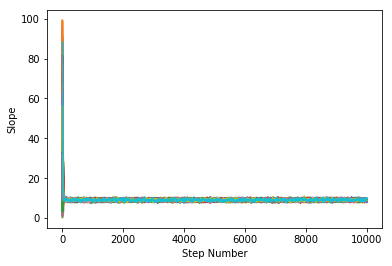

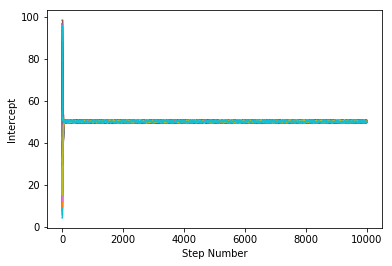

In [6]:
print(sampler.chain.shape)  # check that this has dimensions (n_walkers, n_steps, n_params)

def chain_plots(chain, **kwargs):
    """
    Plot the histories for each walker in sampler.chain
    
    Parameters
    ----------
    chain: ndarray
        3D array given by sampler.flatchain, with shape (n_walkers, n_steps, n_params)
    kwargs: `.Line2D` properties, optional
        All keyword arguments are passed to `pyplot.plot`
    """
    
    plt.figure()
    plt.plot(chain[:, :, 0].T, **kwargs)
    plt.xlabel('Step Number')
    plt.ylabel('Slope')

    plt.figure()
    plt.plot(chain[:, :, 1].T, **kwargs)
    plt.xlabel('Step Number')
    plt.ylabel('Intercept')
    
chain_plots(sampler.chain)

Each one of those colored lines is a walker. They started out at your initial guesses. What do you immediately notice?

Try making more useful plots by zooming in on the relevant parts. Hint: you can adjust line opacity in matplotlib with the `alpha` parameter.

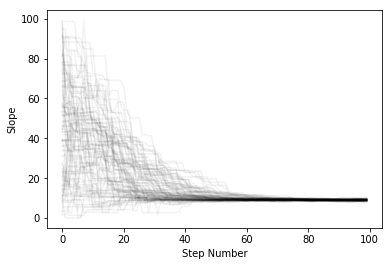

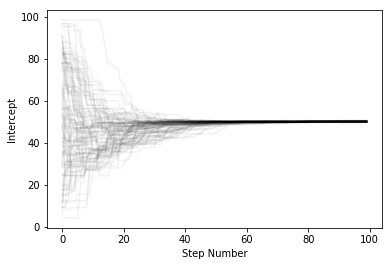

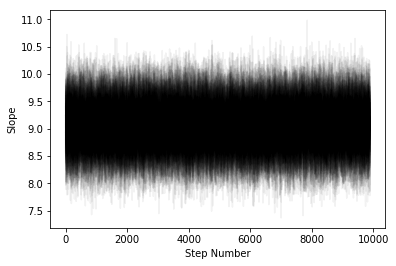

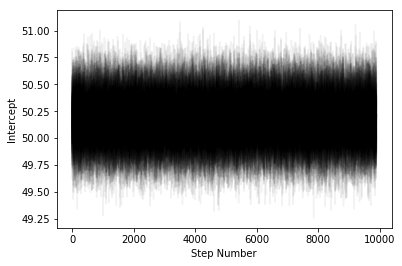

In [7]:
n_burn = 100
chain_plots(sampler.chain[:, :n_burn], color='k', alpha=0.05)
chain_plots(sampler.chain[:, n_burn:], color='k', alpha=0.05)

Are your chains converged? How many steps did it take for this to happen? This is called the "burn-in" period. **From now on, only use the steps after the burn-in period.**

Now make a scatter plot of the two parameters, one point for each walker-step. Hint: `sampler.flatchain`.

Text(0, 0.5, 'Intercept')

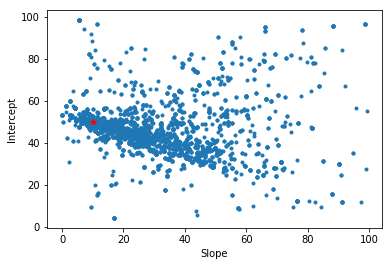

In [8]:
plt.scatter(sampler.flatchain[n_burn:, 0], sampler.flatchain[n_burn:, 1], marker='.')
plt.plot(m, b, 'r*')
plt.xlabel('Slope')
plt.ylabel('Intercept')

How does this compare to the distribution you had in the previous notebook (assuming you used the same parameters)?

Now let's marginalize over each parameter. Given that we have walkers that are distributed according to the 2D posterior, think about how to calculate the marginalized posterior for each parameter.

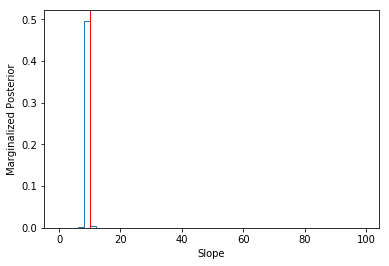

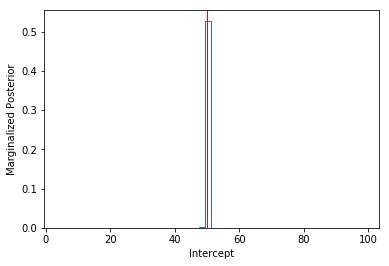

In [9]:
plt.figure()
plt.hist(sampler.flatchain[n_burn:, 0], bins=50, histtype='step', density=True)
plt.xlabel('Slope')
plt.ylabel('Marginalized Posterior')
plt.axvline(m, color='r', lw=1)

plt.figure()
plt.hist(sampler.flatchain[n_burn:, 1], bins=50, histtype='step', density=True)
plt.xlabel('Intercept')
plt.ylabel('Marginalized Posterior')
plt.axvline(b, color='r', lw=1)

There's an easy way to make all these plots: `corner.corner`! Produce a corner plot with the true parameters labeled and the best-fit values (with error bars) printed on the plot. How close did we get to the parameters we used to generate the data?

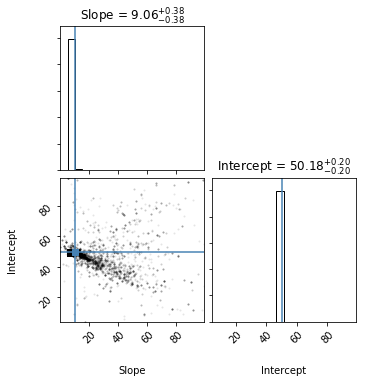

In [10]:
corner.corner(sampler.flatchain[n_burn:], labels=['Slope', 'Intercept'], truths=[m, b], show_titles=True);

## Take-Away Message
MCMC is a much more efficient way to sample the probability distribution because the walkers mostly stay in the highest-probability region. Plus it essentially gives you the marginalized posteriors for free, because the density of walkers matches the probability density.

## Other Things to Try
- Add a parameter for the intrinsic scatter and redo the MCMC fit.
- Try implementing Metropolis-Hastings algorithm yourself and see if you can get the same results as `emcee`.